In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
dev_df = pd.read_csv('../data/train.csv')
del dev_df["Id"]
dev_df = dev_df.drop_duplicates().copy()
dev_df["Prediction"] = dev_df["Prediction"].apply(lambda x: 1 if x == "s" else 0)

train_df, val_df = train_test_split(dev_df, test_size=0.2, stratify=dev_df["Prediction"])
train_df, val_df = train_df.reset_index(drop=True).copy(), val_df.reset_index(drop=True).copy()

test_df = pd.read_csv('../data/test.csv')

In [3]:
train_df.head()

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,0,110.155,82.325,64.889,25.343,-999.000,-999.000,-999.000,2.429,25.343,...,1.958,192.571,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
1,0,75.573,18.205,51.824,62.007,-999.000,-999.000,-999.000,1.827,62.007,...,1.334,124.767,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
2,0,102.933,1.592,50.201,121.316,2.217,205.555,2.974,1.529,72.002,...,-0.686,360.897,3,82.383,-3.159,2.396,65.476,-0.942,3.052,196.178
3,0,337.032,25.851,261.893,396.152,2.709,655.016,-1.639,1.635,100.569,...,1.169,962.820,3,246.202,0.912,-1.926,128.124,-1.797,-1.266,546.367
4,1,119.718,11.698,82.930,0.651,-999.000,-999.000,-999.000,2.980,0.651,...,2.201,86.657,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000


In [4]:
train_df.describe()

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.342670,-49.086426,49.214588,81.182319,57.887892,-708.968029,-601.941348,-709.903190,2.373370,18.890775,...,-0.009348,209.697797,0.978025,-348.331111,-399.268332,-399.272147,-692.952303,-709.667622,-709.665705,73.017009
std,0.474603,406.379973,35.306556,40.891379,63.728654,454.227784,657.543766,452.766344,0.783756,22.422508,...,1.812409,126.549648,0.976221,532.980418,489.340351,489.337300,479.621454,453.132484,453.135224,98.104534
min,0.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,0.000000,78.079000,19.222500,59.359000,14.130250,-999.000000,-999.000000,-999.000000,1.810000,2.839750,...,-1.574000,123.015750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,0.000000,104.996000,46.523000,73.713000,38.463000,-999.000000,-999.000000,-999.000000,2.492000,12.266500,...,-0.023000,179.690500,1.000000,38.934000,-1.875000,-2.090000,-999.000000,-999.000000,-999.000000,40.483000
75%,1.000000,130.649250,73.567000,92.283000,79.045000,0.489000,83.000000,-4.647750,2.962000,27.559000,...,1.562000,263.199500,2.000000,75.247750,0.432000,0.506000,33.617250,-2.464000,-2.286000,109.795500
max,1.000000,1192.026000,571.868000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


<AxesSubplot:>

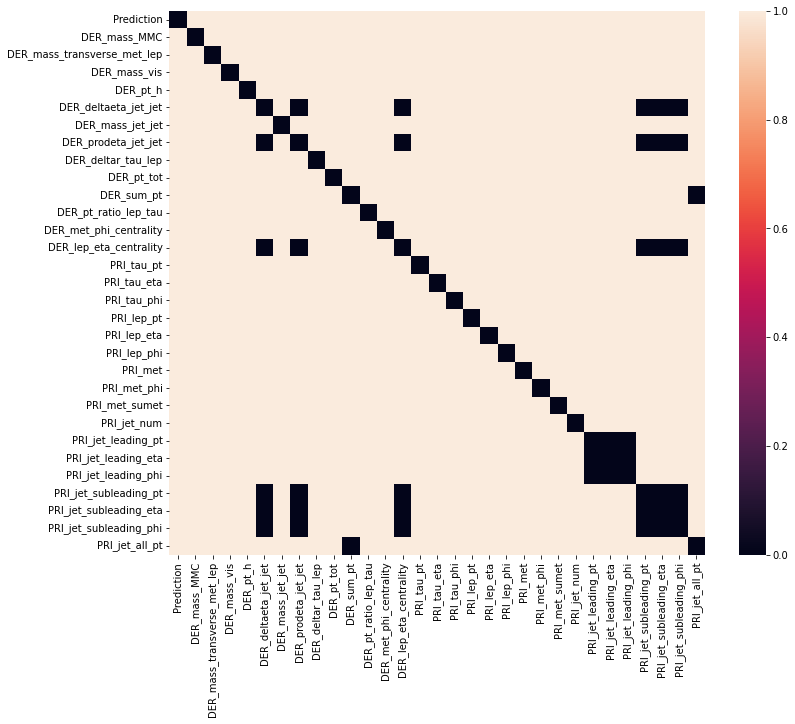

In [5]:
corrMatrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap((corrMatrix < 0.95) & (-0.95 < corrMatrix))

In [6]:
useless = [
    'DER_deltaeta_jet_jet', 
    'DER_prodeta_jet_jet',
    'DER_lep_eta_centrality', 
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi', 
    'PRI_jet_leading_eta', 
    'PRI_jet_leading_phi', 
    'DER_sum_pt', 
]

for col in useless:
    del train_df[col]

<AxesSubplot:>

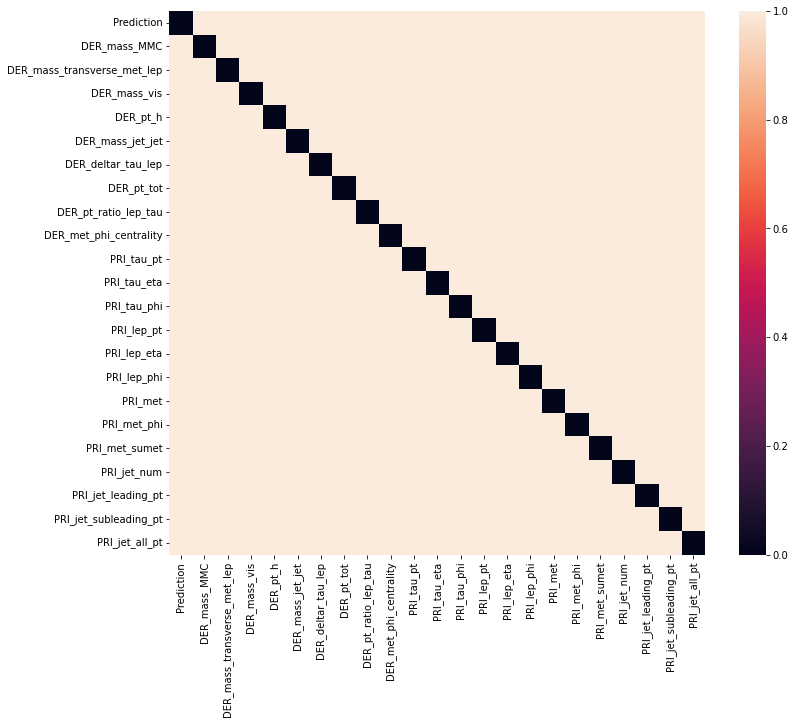

In [7]:
corrMatrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap((corrMatrix < 0.95) & (-0.95 < corrMatrix))

<AxesSubplot:>

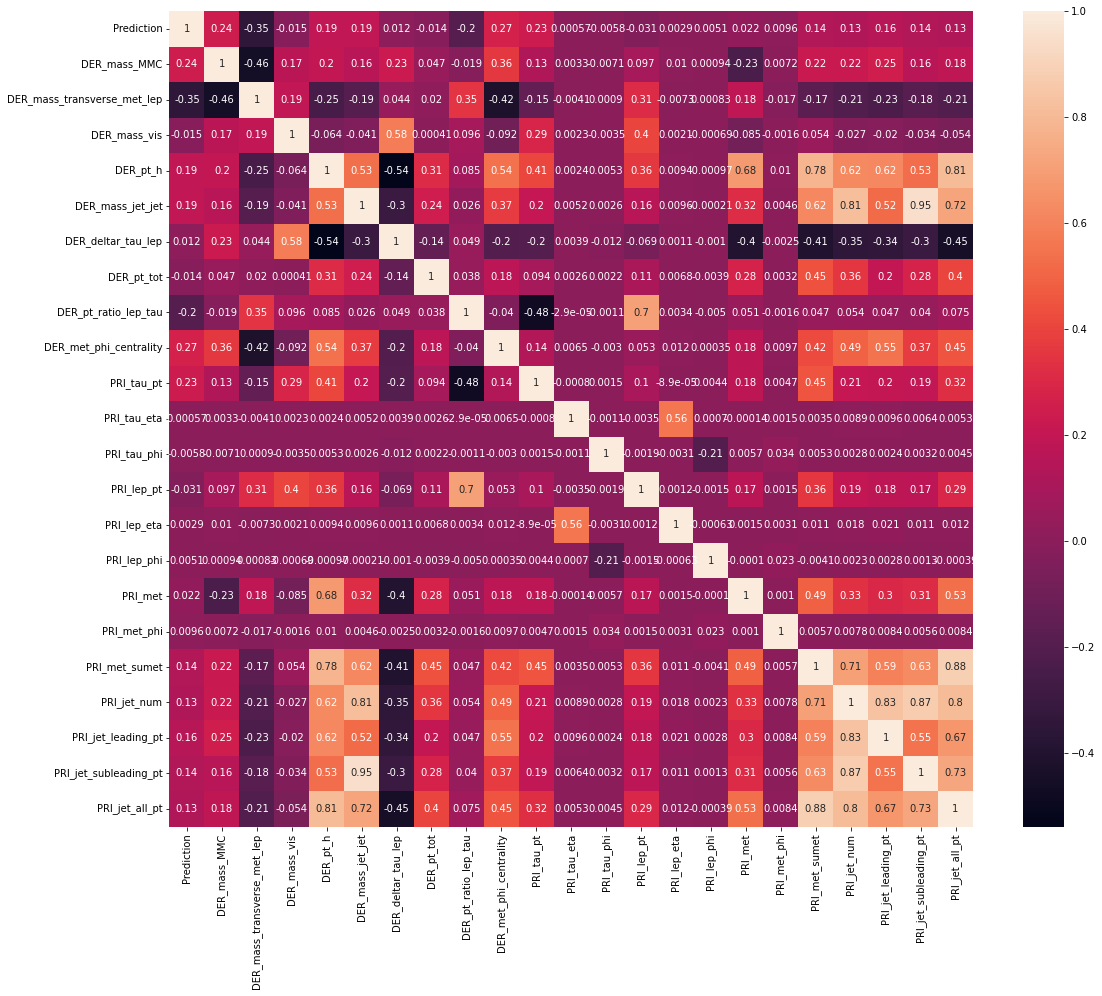

In [8]:
plt.figure(figsize=(18,15))
corrMatrix = train_df.corr()
sns.heatmap(corrMatrix, annot=True)

In [9]:
import numpy as np

In [10]:
train_df[train_df < -998.000] = np.nan
train_df.fillna(train_df.mean(), inplace=True)

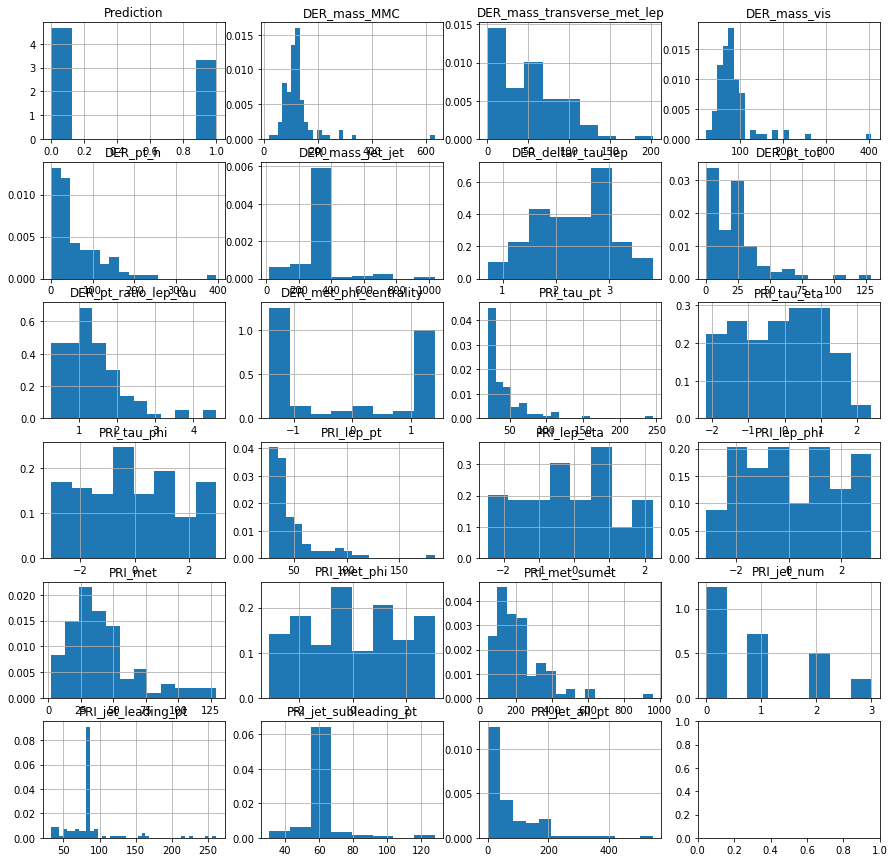

In [11]:
fig, axs = plt.subplots(6, 4, figsize=(15,15))
columns = train_df.columns
for i in range(23):
    train_df.loc[:100, columns[i]].hist(
        bins="auto", 
        density=True, 
        ax=axs[i // 4, i % 4], 
    )
    axs[i // 4, i % 4].set_title(columns[i])

donc en gros, on a enlever les truc trop corélé et après

pour vendredi, faire les code des fonctions de base, regarder pour l'overlafe et clara fait la cross validation pour avoir l'hyperparameter lambda



In [12]:
from implementations import least_squares, least_squares_GD, compute_loss, ridge_regression
from course_functions import build_poly

In [13]:
train_df

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_mass_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,...,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_subleading_pt,PRI_jet_all_pt
0,0,110.155,82.325,64.889,25.343,371.940534,2.429,25.343,2.187,-0.241,...,50.919,-1.662,-0.888,34.016,1.958,192.571,0,84.843003,57.703312,0.000
1,0,75.573,18.205,51.824,62.007,371.940534,1.827,62.007,1.222,1.389,...,36.048,0.312,2.000,21.463,1.334,124.767,0,84.843003,57.703312,0.000
2,0,102.933,1.592,50.201,121.316,205.555000,1.529,72.002,0.746,1.035,...,29.618,2.155,-0.652,74.333,-0.686,360.897,3,82.383000,65.476000,196.178
3,0,337.032,25.851,261.893,396.152,655.016000,1.635,100.569,0.355,1.329,...,87.112,1.842,0.839,70.993,1.169,962.820,3,246.202000,128.124000,546.367
4,1,119.718,11.698,82.930,0.651,371.940534,2.980,0.651,0.604,-1.379,...,32.166,1.402,2.638,22.601,2.201,86.657,0,84.843003,57.703312,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,199.025,99.018,179.523,66.237,371.940534,2.296,2.315,1.233,-1.397,...,92.852,1.963,1.772,37.509,-0.219,258.168,1,64.260000,57.703312,64.260
199996,0,143.111,5.707,89.436,25.043,371.940534,3.114,25.043,0.462,1.401,...,28.627,1.103,1.547,10.609,1.876,156.834,0,84.843003,57.703312,0.000
199997,0,99.636,1.290,64.695,23.854,371.940534,2.762,23.854,0.852,0.842,...,30.382,0.790,-1.128,23.287,-1.079,107.581,0,84.843003,57.703312,0.000
199998,0,88.511,48.581,46.455,43.815,371.940534,2.450,43.815,1.431,1.353,...,28.877,1.345,-0.369,31.479,1.504,143.909,0,84.843003,57.703312,0.000


In [14]:
train_df = pd.concat([train_df, pd.get_dummies(train_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del train_df["PRI_jet_num"]
val_df = pd.concat([val_df, pd.get_dummies(val_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del val_df["PRI_jet_num"]
test_df = pd.concat([test_df, pd.get_dummies(test_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del test_df["PRI_jet_num"]

In [15]:
y_column = "Prediction"
X_columns = [col for col in train_df.columns if col != y_column]

In [16]:
X_train, y_train = train_df[X_columns].values, train_df[y_column].values
X_val, y_val = val_df[X_columns].values, val_df[y_column].values

**PCA and K-clustering**

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

In [18]:
sc = StandardScaler()

X_train_pca = sc.fit_transform(X_train)
X_val_pca = sc.transform(X_val)

In [19]:

pca = PCA(n_components = 2)
 
X_train_pca = pca.fit_transform(X_train_pca)
X_val_pca = pca.transform(X_val_pca)
 
explained_variance = pca.explained_variance_ratio_

In [27]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_pca, y_train)

LogisticRegression(random_state=0)

In [28]:
y_pred = classifier.predict(X_val_pca)

In [29]:
cm = confusion_matrix(y_val, y_pred)

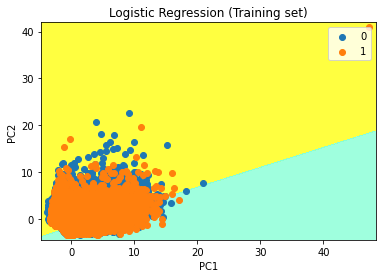

In [34]:
X_set, y_set = X_train_pca, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
 
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
 
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
 
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j)
 
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
 
# show scatter plot
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


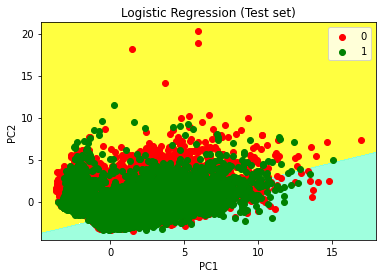

In [31]:
X_set, y_set = X_val_pca, y_val
 
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
 
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
 
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
 
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
 
# title for scatter plot
plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend()
 
# show scatter plot
plt.show()

***Ridge regression*** 

In [17]:
w_pure, loss_tr  = ridge_regression(y_train, X_train, lambda_=0.)
#y_pred = (X_train @ w_pure).reshape(-1, 1)
#y_pred = np.concatenate([1 - y_pred, y_pred], axis=1)
loss_te = compute_loss(y_val, X_val, w_pure)
print(loss_tr, loss_te)
#plot_roc(y_val, y_pred, figsize=(8,8))

0.0850392839326586 0.0969161732692902


cross validation for the lambda params 

In [18]:
from course_functions import build_k_indices, cross_validation

In [19]:
vect = np.array([0, 1, 2, 3, 4, 5])
print(X_train[vect].shape)
print((np.delete(X_train, vect)).shape)

(6, 25)
(4999994,)


In [25]:
seed = 12
degrees = 1
k_fold = 10
lambdas = np.logspace(-4, 0, 30)
k_indices = build_k_indices(y_train, k_fold, seed)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te,_ = cross_validation(y_train, X_train, k_indices, k, lambda_, degrees)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(rmse_tr_tmp))
    rmse_te.append(np.mean(rmse_te_tmp))


plt.plot(lambdas, rmse_tr, lambdas, rmse_te)
plt.legend(['training', 'test'])
plt.show()

(4980000,)
(180000, 1)
(4980000, 2)


ValueError: shapes (2,4980000) and (180000,1) not aligned: 4980000 (dim 1) != 180000 (dim 0)

In [27]:
print(X_train.shape)

(200000, 25)


In [25]:
seed = 12
degrees = [0, 1, 2, 3, 4, 5, 12]
k_fold = 10
lambdas = np.logspace(-4, 0, 30)
k_indices = build_k_indices(y_train, k_fold, seed)
rmse_tr = np.empty((len(lambdas), len(degrees)))
rmse_te = np.empty((len(lambdas), len(degrees)))

for index_lambda, lambda_ in enumerate(lambdas):
    for index_degree, degree in enumerate(degrees):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y_train, X_train, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr[index_lambda][index_degree](np.mean(rmse_tr_tmp))
        rmse_te[index_lambda][index_degree](np.mean(rmse_te_tmp))
    plt.plot(degrees, rmse_tr[:,index_degree], degrees, rmse_te[:,index_degree])
    #plt.legend(['training lambda ', 'test']) regarder comment afficher 
    #la legende pour avoir le lambdas et le degrées, 
    #maybe faire des petits plots
plt.show()

ValueError: shapes (1,4980000) and (180000,) not aligned: 4980000 (dim 1) != 180000 (dim 0)

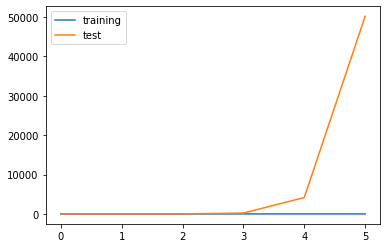

In [24]:
degrees = [0, 1, 2, 3, 4, 5] #more than five = overfitting 
lambda_ = 0.00001 # cross-validation à faire !!  
losses_tr = []
losses_te = []

for degree in degrees: 
    X_train_poly = build_poly(X_train, degree)
    X_val_poly = build_poly(X_val, degree)
    w_tr, loss = ridge_regression(y_train, X_train_poly, lambda_)
    losses_tr.append(loss)
    losses_te.append(compute_loss(y_val, X_val_poly, w_tr))

plt.plot(degrees, losses_tr, degrees, losses_te)
plt.legend(['training', 'test'])
plt.show()

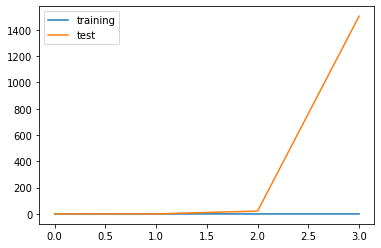

In [23]:
plt.plot(degrees[0:4], losses_tr[0:4], degrees[0:4], losses_te[0:4])
plt.legend(['training', 'test'])
plt.show()

In [22]:
losses_tr[0], losses_te[0]

(0.11425450678472221, 0.11425236236805557)

In [30]:
X_train_concatenate = np.concatenate([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)], axis=1)
X_val_concatenate = np.concatenate([X_val, np.ones(X_val.shape[0]).reshape(-1, 1)], axis=1)

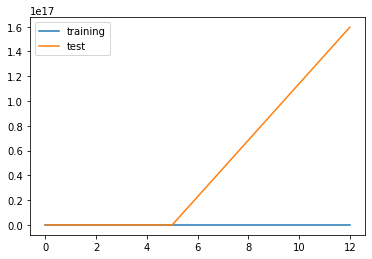

In [24]:
degrees = [0, 1, 2, 3, 4, 5, 12] #more than five = overfitting 
lambda_ = 0.1 # cross-validation à faire !!  
losses_tr = []
losses_te = []

for degree in degrees: 
    X_train_poly = build_poly(X_train_concatenate, degree)
    X_val_poly = build_poly(X_val_concatenate, degree)
    w_tr, loss = ridge_regression(y_train, X_train_poly, lambda_)
    losses_tr.append(loss)
    losses_te.append(compute_loss(y_val, X_val_poly, w_tr))

plt.plot(degrees, losses_tr, degrees, losses_te)
plt.legend(['training', 'test'])
plt.show()

In [25]:
losses_tr[0], losses_te[0]

(0.11425450678472221, 0.11425236236805557)

there is some overfitting, so we can take the 2 or the 4th degree to test the error 

**Least Squares**

In [31]:
W, loss_tr = least_squares(y_train, X_train)
loss_te = compute_loss(y_val, X_val, W)
print(loss_tr, loss_te)

0.0850392839326586 0.0969161732692902


In [29]:
W, loss_tr = least_squares(y_train, X_train_concatenate)
loss_te = compute_loss(y_val, X_val_concatenate, W)
print(loss_tr, loss_te)

NameError: name 'X_train_concatenate' is not defined

In [32]:
degrees = [0, 1, 2, 3, 4, 5, 12] #more than five = overfitting 
lambda_ = 0.1
losses_tr = []
losses_te = []

for degree in degrees: 
    X_train_poly = build_poly(X_train, degree)
    X_val_poly = build_poly(X_val, degree)
    w_tr, loss  = least_squares(y_train, X_train_poly)
    losses_tr.append(loss)
    losses_te.append(compute_loss(y_val, X_val_poly, w_tr))

plt.plot(degrees, losses_tr, degrees, losses_te)
plt.legend(['training', 'test'])
plt.show()

LinAlgError: Singular matrix

**Least Squares Gradient descente**

In [33]:
w_initial = np.zeros(np.shape(X_train)[1])  
max_iters = 50
gamma = 0.7 #il faudra faire une cross-validation ! 

w, L_tr = least_squares_GD(y_train, X_train, w_initial, max_iters, gamma)
loss_te = compute_loss(y_val, X_val, W)
print(loss_tr, loss_te)

Gradient Descent(0/49): loss=0.171335, w0=29.42073845487929, w1=7.68280716
Gradient Descent(1/49): loss=2249109363.3857536, w0=-5381153.216623728, w1=-2062106.077421674
Gradient Descent(2/49): loss=8.077769514678986e+19, w0=1018806218886.0901, w1=391372870016.75665
Gradient Descent(3/49): loss=2.9013474689796645e+30, w0=-1.930655273766611e+17, w1=-7.41728897731194e+16
Gradient Descent(4/49): loss=1.0420974540793728e+41, w0=3.6589336321982204e+22, w1=1.405720939479112e+22
Gradient Descent(5/49): loss=3.7429750300259976e+51, w0=-6.934391139713543e+27, w1=-2.6641174444727143e+27
Gradient Descent(6/49): loss=1.344390778615054e+62, w0=1.3142033741801937e+33, w1=5.049026600652068e+32
Gradient Descent(7/49): loss=4.8287433154873444e+72, w0=-2.490673898157193e+38, w1=-9.568898672126876e+37
Gradient Descent(8/49): loss=1.734373842617709e+83, w0=4.720317010833396e+43, w1=1.8134945434725886e+43
Gradient Descent(9/49): loss=6.229473031438056e+93, w0=-8.94592934432851e+48, w1=-3.436928921814694e+48

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/ML_course/projects/project1/scripts/implementations.py:7: RuntimeWarning: overflow encountered in square
  return 1/2*np.mean(e**2)


Gradient Descent(29/49): loss=inf, w0=-3.1967701706495135e+154, w1=-1.2281643899936166e+154
Gradient Descent(30/49): loss=inf, w0=6.0585083619992385e+159, w1=2.327613131216812e+159
Gradient Descent(31/49): loss=inf, w0=-1.1482065213639327e+165, w1=-4.411284786266347e+164
Gradient Descent(32/49): loss=inf, w0=2.1760772403516429e+170, w1=8.360252485503068e+169
Gradient Descent(33/49): loss=inf, w0=-4.124094461988799e+175, w1=-1.584432314117663e+175
Gradient Descent(34/49): loss=inf, w0=7.815970323120632e+180, w1=3.002810934685772e+180
Gradient Descent(35/49): loss=inf, w0=-1.4812801368871351e+186, w1=-5.690917452974157e+185
Gradient Descent(36/49): loss=inf, w0=2.8073172660925745e+191, w1=1.0785408126254526e+191
Gradient Descent(37/49): loss=inf, w0=-5.320418492253079e+196, w1=-2.0440470172183568e+196
Gradient Descent(38/49): loss=inf, w0=1.0083239708815672e+202, w1=3.873871215340098e+201
Gradient Descent(39/49): loss=inf, w0=-1.9109722886174977e+207, w1=-7.34174804523954e+206
Gradient D

In [34]:
degrees = [0, 1, 2, 3, 4, 5] #more than five = overfitting 
max_iters = 50
gamma = 0.7 #il faudra faire une cross-validation ! 
w_initial = np.zeros(np.shape(X_train)[1])
losses_tr = []
losses_te = []

for degree in degrees: 
    X_train_poly = build_poly(X_train, degree)
    X_val_poly = build_poly(X_val, degree)
    w, L_tr = least_squares_GD(y_train, X_train_poly, w_initial, max_iters, gamma)
    losses_tr.append(loss)
    losses_te.append(compute_loss(y_val, X_val_poly, w_tr))

plt.plot(degrees, losses_tr, degrees, losses_te)
plt.legend(['training', 'test'])
plt.show()

ValueError: shapes (200000,1) and (25,) not aligned: 1 (dim 1) != 25 (dim 0)